# Poisson GLM: Horseshoe Crab Mating Example

Study of nesting horseshoe crabs: each female horseshoe crab had a male crab resident in her nest. The study investigated factors affecting whether the female crab had any other males, called satellites, residing nearby, and if so, how many. The factors included the female crab's color, spine condition, weight, and carapace width.

From Alan Agresti, *Categorical Data Analysis,* Second Edition, Wiley, 2002, pg. 126 (https://mathdept.iut.ac.ir/sites/mathdept.iut.ac.ir/files/AGRESTI.PDF).

In [1]:
'''
Imports
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

/Users/julialintern/anaconda/envs/mypython3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
'''
Read in input file into Pandas dataframe. The columns have the following meaning:
1. Color: 1 (light medium), 2 (medium), 3 (dark medium), 4 (dark)
2. Spine condition: 1 (both good), 2 (one worn or broken), 3 (both worn or broken)
3. Carapace width: in cm
4. Weight: in kg
5. Number of satellites
'''
df0 = pd.read_csv('CrabSatellites.ssv', sep='\s+', header=None, names=['Color', 'Spine', 'Width', 'Weight', 'Satellites'])
df0['Color'] = df0['Color'].astype('category')
df0['Spine'] = df0['Spine'].astype('category')
print (df0.head())
print('\n')
print (df0.describe())

  Color Spine  Width  Weight  Satellites
0     2     3   28.3    3.05           8
1     3     3   26.0    2.60           4
2     3     3   25.6    2.15           0
3     4     2   21.0    1.85           0
4     2     3   29.0    3.00           1


            Width      Weight  Satellites
count  173.000000  173.000000  173.000000
mean    26.298844    2.437225    2.919075
std      2.109061    0.577255    3.148336
min     21.000000    1.200000    0.000000
25%     24.900000    2.000000    0.000000
50%     26.100000    2.350000    2.000000
75%     27.700000    2.850000    5.000000
max     33.500000    5.200000   15.000000


In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 5 columns):
Color         173 non-null category
Spine         173 non-null category
Width         173 non-null float64
Weight        173 non-null float64
Satellites    173 non-null int64
dtypes: category(2), float64(2), int64(1)
memory usage: 4.8 KB


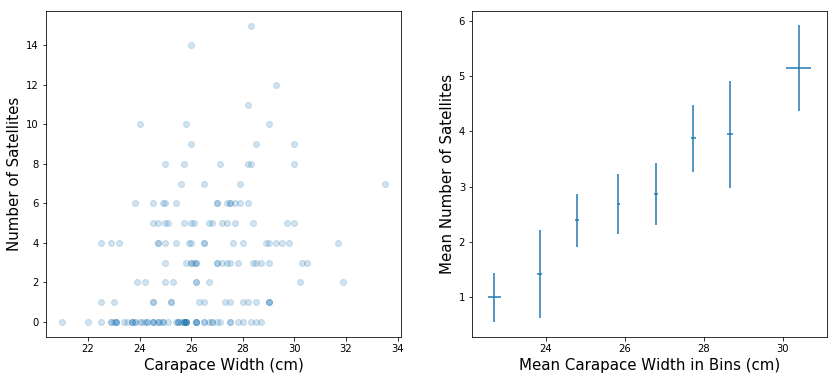

In [11]:
'''
Plot number of satellites versus carapace width.
'''
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ax[0].scatter(df0.Width, df0.Satellites, alpha=0.2)
ax[0].set_xlabel('Carapace Width (cm)', fontsize=15)
ax[0].set_ylabel('Number of Satellites', fontsize=15)

bins = np.linspace(23.25, 29.25, 7)
# digitize ~ Return the indices of the bins to which each value in input array belongs
df0['bin'] = np.digitize(df0.Width, bins=bins)
bingroups = df0.groupby('bin')
widths = bingroups['Width'].agg(['mean', 'sem']) #  sem ~ std error of mean
satels = bingroups['Satellites'].agg(['mean', 'sem'])
xval = widths.iloc[:,0]
xerr = widths.iloc[:,1]
yval = satels.iloc[:,0]
yerr = satels.iloc[:,1]
ax[1].errorbar(x=xval, y=yval, yerr=yerr, xerr=xerr, linestyle='none')
ax[1].set_xlabel('Mean Carapace Width in Bins (cm)', fontsize=15)
ax[1].set_ylabel('Mean Number of Satellites', fontsize=15)

plt.show()

In [16]:
'''
Fit a Poisson GLM model. For now we consider a single predictor, the carapace width,
and wish to predict the number of satellites.
The link function below uses sm.families.links.log, but one could also try sm.families.links.identity.
'''
formula = 'Satellites ~ Width'
PoissonModel = smf.glm(formula=formula, data=df0, family=sm.families.Poisson(link=sm.families.links.log))
PoissonResults = PoissonModel.fit()
print (PoissonResults.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Satellites   No. Observations:                  173
Model:                            GLM   Df Residuals:                      171
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -461.59
Date:                Tue, 13 Feb 2018   Deviance:                       567.88
Time:                        07:53:59   Pearson chi2:                     544.
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3048      0.542     -6.095      0.000      -4.368      -2.242
Width          0.1640      0.020      8.216      0.0

### Interpretation of the results:

- For the log link: $\mu = \exp(-3.30 + 0.16*x) = 0.037*(1.18)^{x}$. If the carapace width increases by 1 cm, the estimated mean number of satellites increases by 18%.

- For the identity link: $\mu = -11.53 + 0.55*x$. If the carapace width increases by 1 cm, the estimated mean number of satellites increases by 0.55. A ~2cm increase in width is associated with an extra satellite.

- Note however that the deviance of the fit is not very good: more than 500, for 171 degrees of freedom. More on this later.

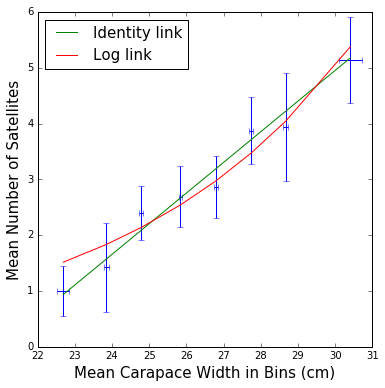

In [5]:
'''
Superimpose fit results on data points.
'''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax.errorbar(x=xval, y=yval, yerr=yerr, xerr=xerr, linestyle='none')
idfit = -11.5318 + 0.5495*np.array(xval)
logfit = np.exp(-3.3048 + 0.1640*np.array(xval))
ax.plot(xval, idfit, label='Identity link')
ax.plot(xval, logfit, label='Log link')
ax.set_xlabel('Mean Carapace Width in Bins (cm)', fontsize=15)
ax.set_ylabel('Mean Number of Satellites', fontsize=15)
ax.legend(prop={'size': 15}, loc="upper left")
plt.show()

- The fit looks good for both link functions. 
- As noted before however, the deviance is large. 
- The large deviance could indicate that the proposed model (Poisson) is incorrect, or that there is overdispersion. Let's check the latter first.

In [6]:
'''
Check for overdispersion.
'''
satels4 = bingroups['Satellites'].agg(['count', 'sum', 'mean', 'var'])
print satels4

     count  sum      mean        var
bin                                 
0       14   14  1.000000   2.769231
1       14   20  1.428571   8.879121
2       28   67  2.392857   6.543651
3       39  105  2.692308  11.376518
4       22   63  2.863636   6.885281
5       24   93  3.875000   8.809783
6       18   71  3.944444  16.879085
7       14   72  5.142857   8.285714


Note how the variance is quite a bit larger than the mean. For Poisson counts, mean and variance should be equal. This non-Poisson behavior is called **overdispersion**. Possible causes include:
- **Missing Features**: We only used carapace width to predict the number of satellites in our model. Maybe the number of satellites is Poisson distributed at each fixed combination of width, weigth, spine condition, color, and perhaps some other features we didn't think about. By using only one predictor out of four or more, we caused the response variable to be a mixture of Poisson populations, each with its own mean.
- **The True Model Is Not Poisson**: Another possible model is the negative binomial, which has an extra parameter to model variability.


One way to fix overdispersion is to try a different model, one with an additional parameter to allow modeling of variability. A good candidate for the case at hand is the negative binomial GLM. The negative binomial distribution has probability mass function:

[neg binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution)
where negative binomial distribution is the # of trials needed to get some # of successes

The mean and variance of the negative binomial distribution are given by:
\begin{equation}
{\rm E}(Y) = \mu\quad\textrm{ and }\quad {\rm Var}(Y) = \mu + \frac{\mu^{2}}{k}.
\end{equation}
Note that mean and variance are not in a one-to-one relationship since the variance involves the new parameter $k$. For large $k$ we recover the Poisson distribution (where variance equals mean).

In [7]:
'''
Fit a negative binomial GLM.
The parameter alpha in the glm call below corresponds to 1/k in the formula for the negative
binomial distribution.
Try playing around with the link function (log or identity) and alpha values (from 0.1 to 2.0).
'''
formula = 'Satellites ~ Width'
NegBinModel = smf.glm(formula=formula, data=df0, 
                      family=sm.families.NegativeBinomial(link=sm.families.links.log, alpha=1.0))
NegBinResults = NegBinModel.fit()
print NegBinResults.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Satellites   No. Observations:                  173
Model:                            GLM   Df Residuals:                      171
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                  0.908134006754
Method:                          IRLS   Log-Likelihood:                -375.80
Date:                Wed, 02 Aug 2017   Deviance:                       206.41
Time:                        17:38:13   Pearson chi2:                     155.
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.0323      1.076     -3.749      0.000        -6.140    -1.924
Width          0.1913      0.040      4.732      0.0

The deviance is significantly better for the negative binomial model! Note that the standard errors on the coefficients have doubled compared to the results of the Poisson GLM. The coefficients themselves have changed much less.

In [8]:
'''
Fit a Poisson GLM model to all the predictors
'''
formula = 'Satellites ~ Color+Spine+Width+Weight'
PoissonModel = smf.glm(formula=formula, data=df0, family=sm.families.Poisson(link=sm.families.links.log))
PoissonResults = PoissonModel.fit()
print PoissonResults.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Satellites   No. Observations:                  173
Model:                            GLM   Df Residuals:                      165
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -452.43
Date:                Wed, 02 Aug 2017   Deviance:                       549.56
Time:                        17:38:29   Pearson chi2:                     534.
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.3572      0.967     -0.369      0.712        -2.253     1.538
Color[T.2]    -0.2649      0.168     -1.576      0.1

Including all four predictors has not improved the deviance. In fact, the spine condition appears to be useless as predictor, and width is also useless in the presence of weight. Intuitively it is clear that width and weight must be strongly correlated. 

In conclusion, adding missing features has not improved this model, but changing from Poisson to negative binomial has.